In [1]:
!pip install pandas darts matplotlib pmdarima fbprophet xgboost tensorflow


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/5.8 MB ? eta -:--:--
     ----- ---------------------------------- 0.8/5.8 MB 3.7 MB/s eta 0:00:02
     ------- -------------------------------- 1.0/5.8 MB 2.8 MB/s eta 0:00:02
     --------- ------------------------------ 1.3/5.8 MB 2.2 MB/s eta 0:00:02
     ------------ --------------------------- 1.8/5.8 MB 2.2 MB/s eta 0:00:02
     ---------------- ----------------------- 2.4/5.8 MB 2.1 MB/s eta 0:00:02
     ------------------ --------------------- 2.6/5.8 MB 2.1 MB/s eta 0:00:02
     -------------------- ------------------- 2.9/5.8 MB 2.0 MB/s eta 0:00:02
     ----------------------- ---------------- 3.4/5.8 MB 2.0 MB/s eta 0:00:02
     --------------------------- ------------ 3.9/5.8 MB 2.0 MB/s eta 0:00:01
     ----------------------------- ---------- 4.2/5.

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [71 lines of output]
      C:\Users\dell\AppData\Local\Temp\pip-install-8tuub9wn\fbprophet_75f9e4c23899445db33e9785c457af59\setup.py:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
        from pkg_resources import (
      C:\Users\dell\AppData\Local\Temp\pip-install-8tuub9wn\fbprophet_75f9e4c23899445db33e9785c457af59\setup.py:19: SetuptoolsDeprecationWarning: The test command is disabled and references to it are deprecated.
      !!
      
              ********************************************************************************
              Please remove any references to `setuptools.command.test` in all supported versions of the affected package.
      
              By 2024-Nov-15, you need to update your project and remove deprecated calls
              or your builds will no longer

In [1]:
import pandas as pd

# Load your dataset
data = pd.read_csv('train.csv')  # Replace with your actual file path

# Convert 'date' column to datetime, handling invalid date formats
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Drop rows with invalid date formats
data = data.dropna(subset=['date'])

# Group by store, item, and date, summing sales across duplicates
data = data.groupby(['store', 'item', 'date']).agg({'sales': 'sum'}).reset_index()

# Get the unique store-item pairs
store_item_pairs = data[['store', 'item']].drop_duplicates()

print(len(data))


913000


In [2]:
data

,store,item,date,sales
0,1,1,2013-01-01,13
1,1,1,2013-01-02,11
2,1,1,2013-01-03,14
3,1,1,2013-01-04,13
4,1,1,2013-01-05,10
...,...,...,...,...
912995,10,50,2017-12-27,63
912996,10,50,2017-12-28,59
912997,10,50,2017-12-29,74
912998,10,50,2017-12-30,62


Importing plotly failed. Interactive plots will not work.


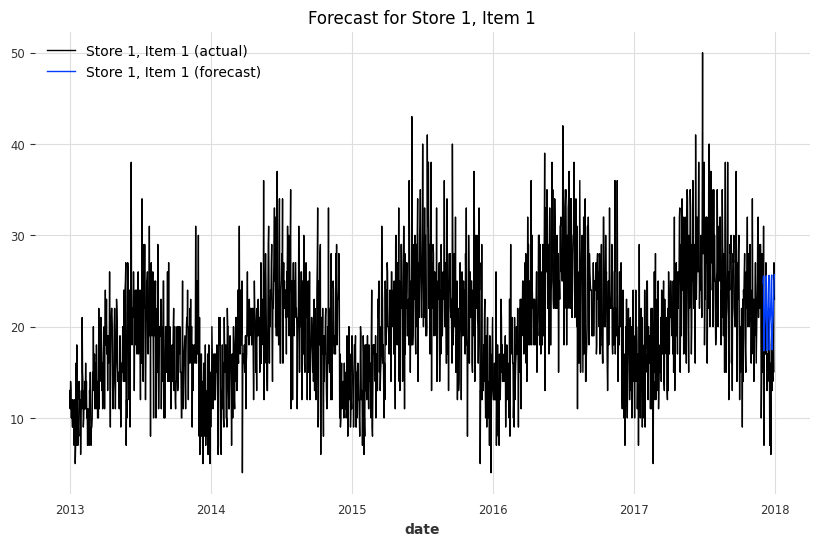

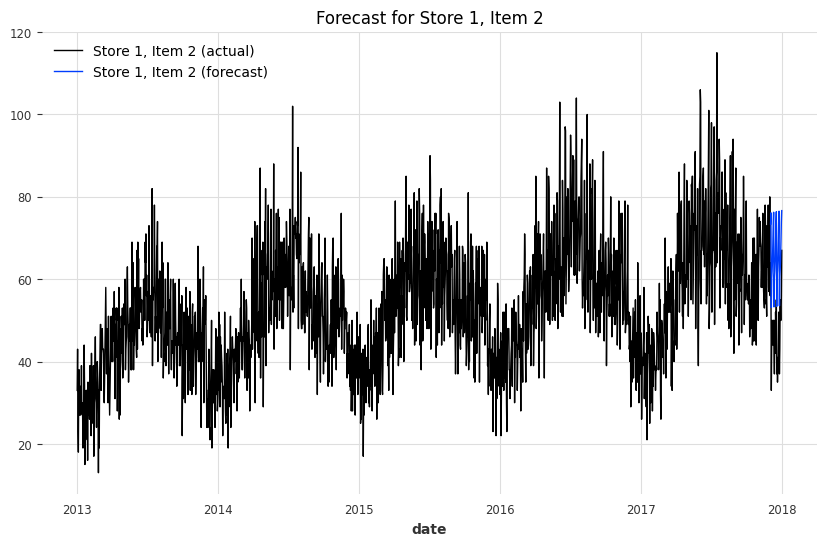

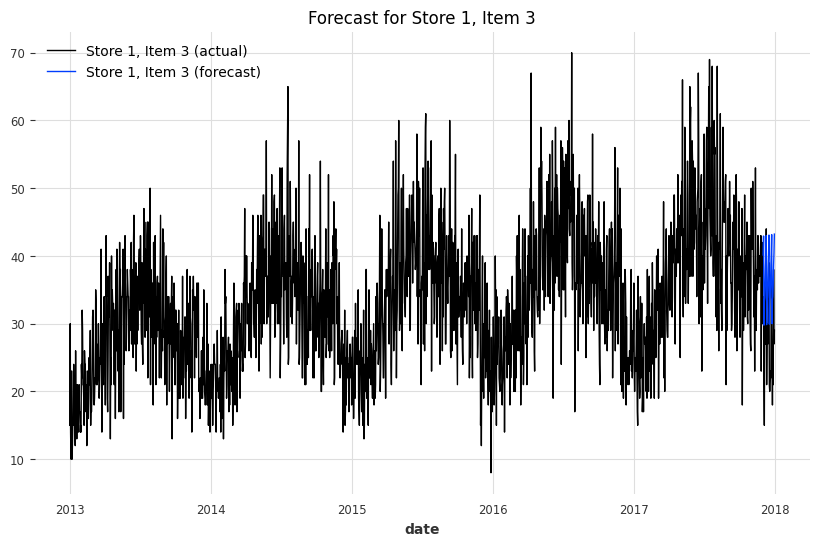

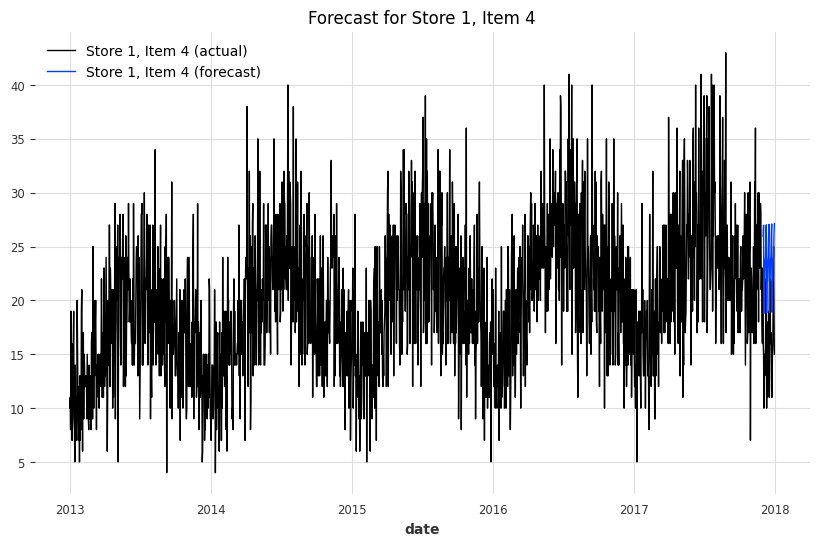

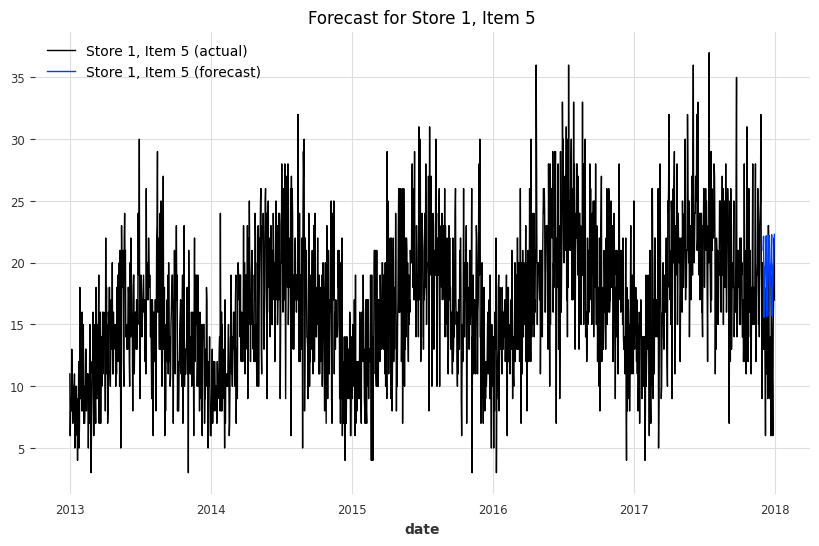

In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing
import matplotlib.pyplot as plt
import gc

# Load your dataset (limit rows for debugging if necessary)
data = pd.read_csv('train.csv', usecols=['store', 'item', 'date', 'sales'])  # Adjust the file path as needed

# Convert 'date' column to datetime, handle invalid formats
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data = data.dropna(subset=['date'])

# Group by store, item, and date, summing sales across duplicates
data = data.groupby(['store', 'item', 'date']).agg({'sales': 'sum'}).reset_index()

# Focus on Store 1 only
store_1_data = data[data['store'] == 1]

# Select the first 5 unique products for Store 1
products = store_1_data['item'].unique()[:5]

# Filter the dataset for only the first 5 products of Store 1
filtered_data = store_1_data[store_1_data['item'].isin(products)]

# Iterate through each product (from the first 5) in Store 1 and apply forecasting
for item in filtered_data['item'].unique():
    item_data = filtered_data[filtered_data['item'] == item]

    # Set the date column as the index and ensure it is sorted
    item_data = item_data.set_index('date').sort_index()

    # Create a TimeSeries for the current product
    series = TimeSeries.from_dataframe(item_data, value_cols=['sales'], freq='D', fill_missing_dates=True)

    # Split the series into training and validation (e.g., last 30 days for validation)
    train, val = series[:-30], series[-30:]

    # Exponential Smoothing model
    model = ExponentialSmoothing()
    model.fit(train)

    # Predict the next 30 days (length of the validation set)
    prediction = model.predict(len(val))

    # Plot the actual and forecasted values
    plt.figure(figsize=(10, 6))
    series.plot(label=f"Store 1, Item {item} (actual)", lw=1)
    prediction.plot(label=f"Store 1, Item {item} (forecast)", lw=1)
    plt.legend(loc='best')
    plt.title(f"Forecast for Store 1, Item {item}")
    plt.show()

    # Clear memory after each loop
    gc.collect()


Forecasting for Store 1, Item 1 using Exponential Smoothing...
Forecasting for Store 1, Item 1 using ARIMA...


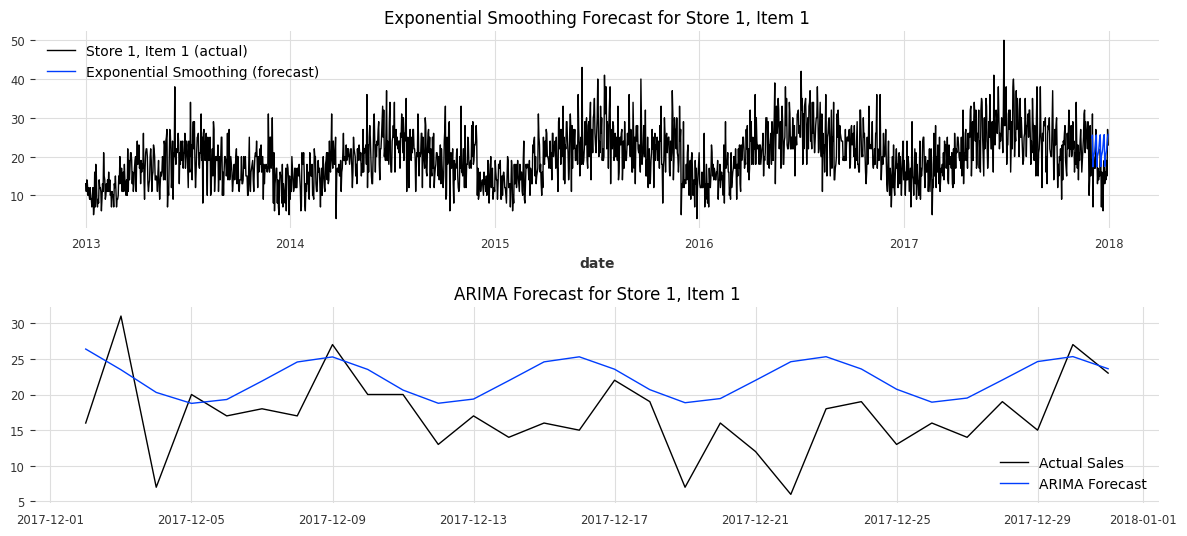

Forecasting for Store 1, Item 2 using Exponential Smoothing...
Forecasting for Store 1, Item 2 using ARIMA...


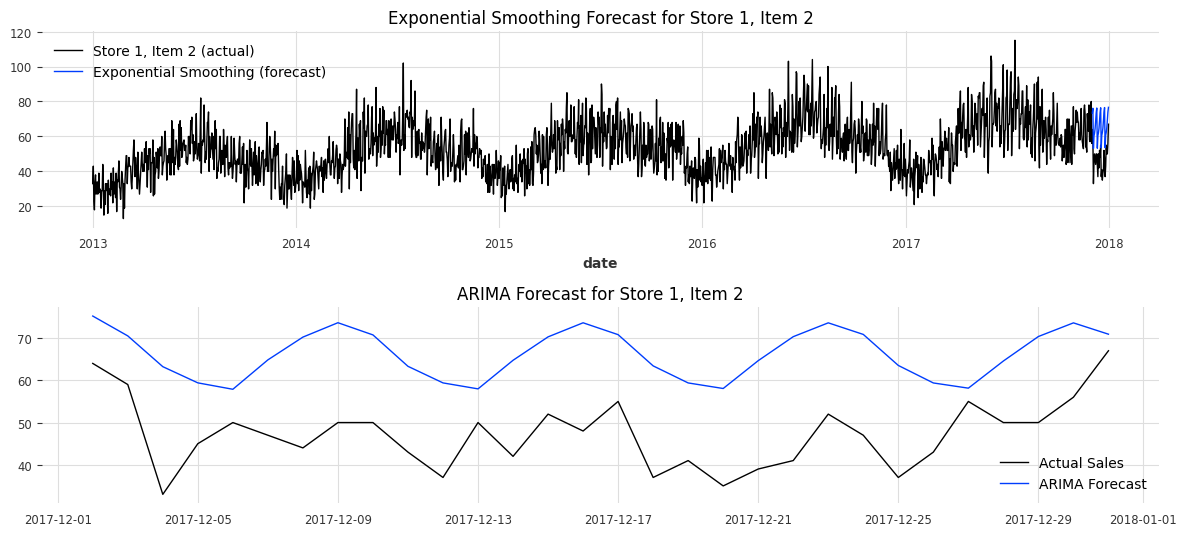

Forecasting for Store 1, Item 3 using Exponential Smoothing...
Forecasting for Store 1, Item 3 using ARIMA...


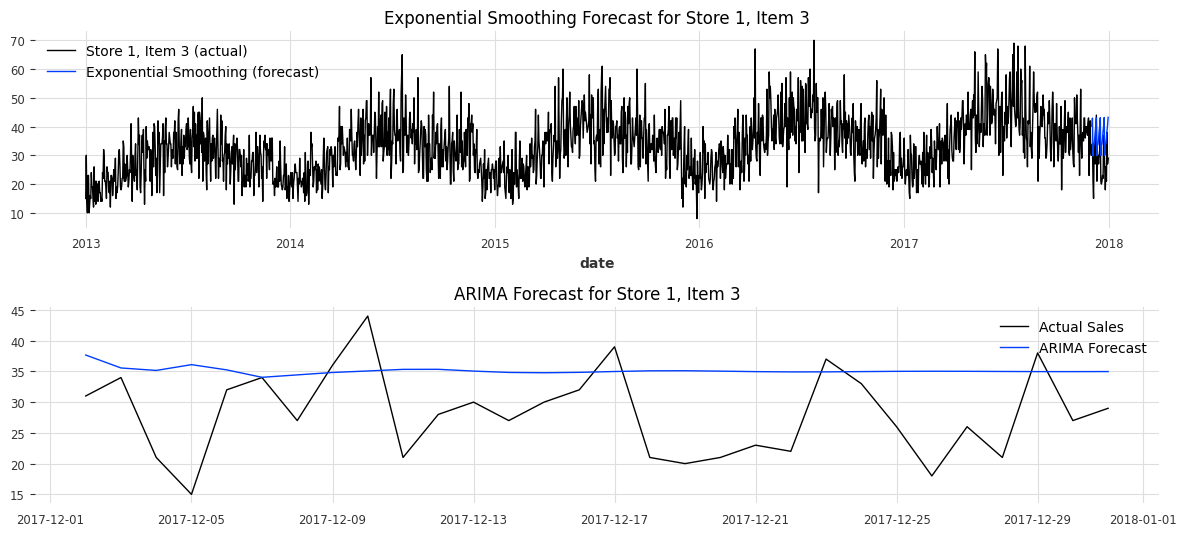

Forecasting for Store 1, Item 4 using Exponential Smoothing...
Forecasting for Store 1, Item 4 using ARIMA...


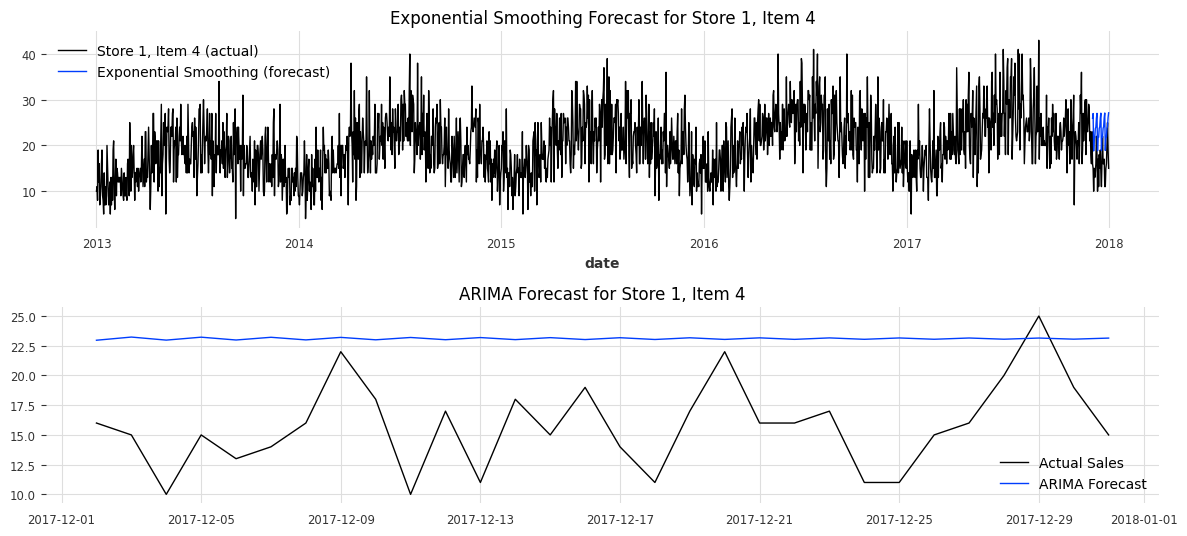

Forecasting for Store 1, Item 5 using Exponential Smoothing...
Forecasting for Store 1, Item 5 using ARIMA...


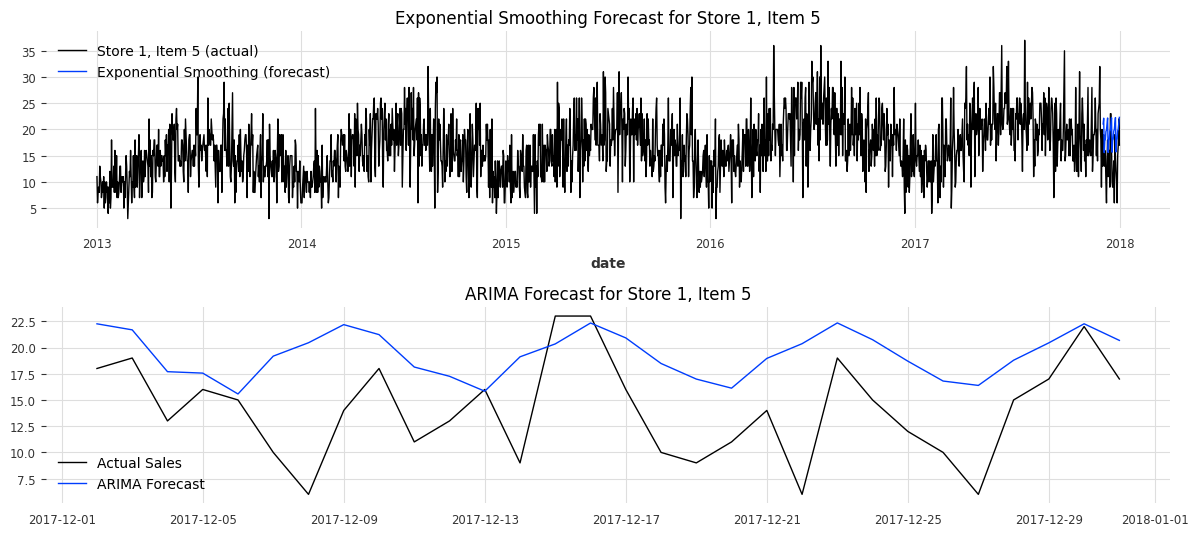

In [8]:
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing
import pmdarima as pm

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import gc

# Load the dataset (adjust file path as needed)
data = pd.read_csv('train.csv', usecols=['store', 'item', 'date', 'sales'])  # Adjust the file path as needed

# Convert 'date' column to datetime and drop rows with invalid dates
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data = data.dropna(subset=['date'])

# Group by store, item, and date, summing sales across duplicates
data = data.groupby(['store', 'item', 'date']).agg({'sales': 'sum'}).reset_index()

# Focus on Store 1 only and select the first 5 products
store_1_data = data[data['store'] == 1]
products = store_1_data['item'].unique()[:5]
filtered_data = store_1_data[store_1_data['item'].isin(products)]

# Iterate through each product (from the first 5) in Store 1 and apply forecasting using different techniques
for item in filtered_data['item'].unique():
    item_data = filtered_data[filtered_data['item'] == item]
    
    # Set the date column as the index and ensure it is sorted
    item_data = item_data.set_index('date').sort_index()

    # Create a TimeSeries object for Darts-based models
    series = TimeSeries.from_dataframe(item_data, value_cols=['sales'], freq='D', fill_missing_dates=True)
    
    # Split the series into training and validation (e.g., last 30 days for validation)
    train, val = series[:-30], series[-30:]

    # --- Technique 1: Exponential Smoothing ---
    print(f"Forecasting for Store 1, Item {item} using Exponential Smoothing...")
    model_es = ExponentialSmoothing()
    model_es.fit(train)
    prediction_es = model_es.predict(len(val))

    # --- Technique 2: ARIMA ---
    print(f"Forecasting for Store 1, Item {item} using ARIMA...")
    train_arima = item_data[:-30]['sales']
    test_arima = item_data[-30:]['sales']
    model_arima = pm.auto_arima(train_arima, seasonal=False, stepwise=True)
    forecast_arima = model_arima.predict(n_periods=30)

   

    # Plot the results from all techniques
    plt.figure(figsize=(12, 8))

    # Plot Exponential Smoothing results
    plt.subplot(3, 1, 1)
    series.plot(label=f"Store 1, Item {item} (actual)", lw=1)
    prediction_es.plot(label=f"Exponential Smoothing (forecast)", lw=1)
    plt.legend(loc='best')
    plt.title(f"Exponential Smoothing Forecast for Store 1, Item {item}")

    # Plot ARIMA results
    plt.subplot(3, 1, 2)
    plt.plot(item_data.index[-30:], test_arima, label='Actual Sales', lw=1)
    plt.plot(item_data.index[-30:], forecast_arima, label='ARIMA Forecast', lw=1)
    plt.legend(loc='best')
    plt.title(f"ARIMA Forecast for Store 1, Item {item}")

    

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Clear memory after each loop
    gc.collect()


In [6]:
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/5.8 MB ? eta -:--:--
     ------- -------------------------------- 1.0/5.8 MB 5.0 MB/s eta 0:00:01
     -------------- ------------------------- 2.1/5.8 MB 5.1 MB/s eta 0:00:01
     ----------------------- ---------------- 3.4/5.8 MB 5.9 MB/s eta 0:00:01
     ---------------------------------- ----- 5.0/5.8 MB 6.3 MB/s eta 0:00:01
     ---------------------------------------- 5.8/5.8 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of pystan to determine which version is compatible with other requireme

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [71 lines of output]
      C:\Users\dell\AppData\Local\Temp\pip-install-0ygj40kd\fbprophet_22032760914e487fae1faa1a5bb4bb6c\setup.py:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
        from pkg_resources import (
      C:\Users\dell\AppData\Local\Temp\pip-install-0ygj40kd\fbprophet_22032760914e487fae1faa1a5bb4bb6c\setup.py:19: SetuptoolsDeprecationWarning: The test command is disabled and references to it are deprecated.
      !!
      
              ********************************************************************************
              Please remove any references to `setuptools.command.test` in all supported versions of the affected package.
      
              By 2024-Nov-15, you need to update your project and remove deprecated calls
              or your builds will no longer